In [1]:
%%capture
!pip3 install tensorflow==2.0.0-beta1

# Load the TensorBoard notebook extension
# Restart the jupyter notebook if you just installed TF 2.0 Beta
%load_ext tensorboard

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import gym
import datetime
from tqdm import tqdm

In [3]:
!rm -rf ./logs/

# Go Environment
Train on a small board with heuristic reward for fast training and efficient debugging

In [4]:
go_env = gym.make('gym_go:go-v0', size='S', reward_method='heuristic')

In [5]:
board_size = 7

# Machine Learning Models
Actor-Critic method

In [6]:
from tensorflow.keras import layers

In [7]:
actor = tf.keras.Sequential([
    layers.Conv2D(input_shape=(board_size, board_size, 4), bias_initializer="ones", 
                  filters=16, kernel_size=5, padding="same"),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=64, kernel_size=5, padding="same"),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=64, kernel_size=5, padding="same"),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=16, kernel_size=5, padding="same"),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=1, kernel_size=5, padding="same"),
    layers.Flatten(),
    layers.Softmax(),
    layers.Reshape((board_size, board_size))
])

In [8]:
critic = tf.keras.Sequential([
    layers.Conv2D(input_shape=(board_size, board_size, 4), bias_initializer="ones", 
                  filters=16, kernel_size=5, padding="same"),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=64, kernel_size=5, padding="same"),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=64, kernel_size=5, padding="same"),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=16, kernel_size=5, padding="same"),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=1, kernel_size=5, padding="same"),
    layers.Reshape((board_size, board_size))
])

In [9]:
state = go_env.reset()
state, reward, done, info = go_env.step((3,5))
state, reward, done, info = go_env.step((5,3))

In [10]:
def plot_state(state, channels_last=False):
    plt.figure()
    for i, (layer, name) in enumerate(zip([state[0], state[1], state[2], state[3]] if not channels_last else 
                                          [state[:,:,0], state[:,:,1], state[:,:,2], state[:,:,3]], 
                                          ['black', 'white', 'ko', 'pass'])):
        plt.subplot(1,4,i+1)
        plt.title(name)
        plt.imshow(layer)
    plt.tight_layout()

Tensorflow expects images to be `channels last`. 

This can be adapted to with `tranpose`.


Ensure the `transpose` function doesn't change anything visually

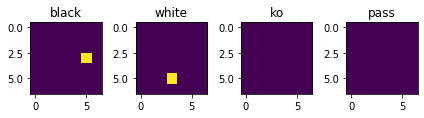

In [11]:
plot_state(state, channels_last=False)

In [12]:
state = state.transpose(1,2,0).reshape(1,7,7,4)

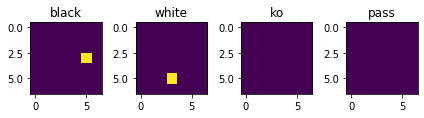

In [13]:
plot_state(state[0], channels_last=True)

### Initialization of models should be random

In [14]:
probs = actor.predict(state)

In [15]:
values = critic.predict(state)

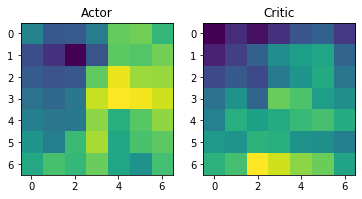

In [16]:
plt.subplot(1,2,1)
plt.title('Actor')
plt.imshow(probs[0])
plt.subplot(1,2,2)
plt.title('Critic')
plt.imshow(values[0])

# Training Setup

### Hyperparameters

In [17]:
NUM_EPISODES = 10
BATCH_SIZE = 64
REPLAY_MEM_SIZE = 1e6
OPPONENT_UPDATE = 10

In [18]:
from collections import deque

In [19]:
memory = deque(maxlen=int(REPLAY_MEM_SIZE))

### Metrics and Tensorboard

Metrics

In [20]:
actor_loss = tf.keras.metrics.Mean('actor_loss', dtype=tf.float32)
critic_loss = tf.keras.metrics.Mean('critic_loss', dtype=tf.float32)

Tensorboard

In [21]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

Demo usage for tensorboard

In [30]:
%tensorboard --logdir logs/gradient_tape

Reusing TensorBoard on port 6006 (pid 59977), started 0:11:18 ago. (Use '!kill 59977' to kill it.)

In [23]:
import random
for episode in tqdm(range(NUM_EPISODES)):
    # Pretend we just played
    
    # Simulate actor losses per batch
    for _ in range(1000):
        batch_actor_loss = random.uniform(0,10)
        
        # Add it to the metric
        actor_loss(batch_actor_loss)
                
    # Simulate critic losses per batch
    for _ in range(1000):
        batch_critic_loss = random.uniform(0,10)
        
        # Add it to the metric
        critic_loss(batch_critic_loss)
    
    with train_summary_writer.as_default():
        # Update tensorboard with metric
        tf.summary.scalar('critic loss', critic_loss.result(), step=episode)
        # Update tensorboard with metric
        tf.summary.scalar('actor loss', actor_loss.result(), step=episode)

    # Reset the metrics
    actor_loss.reset_states()
    critic_loss.reset_states()

100%|██████████| 10/10 [00:07<00:00,  1.24it/s]


### Functions

In [24]:
def play():
    pass

In [25]:
def update_critic():
    pass

In [26]:
def update_actor():
    pass

In [27]:
def train(episode):
    if episode % OPPONENT_UPDATE == 0:
        # TODO sync opponent
        pass
    
    play()
    update_critic()
    
    update_actor()

# Train

In [28]:
for episode in range(NUM_EPISODES):
    train(episode)

# Evaluate
Play against the actor 💪

In [29]:
env = gym.make('gym_go:go-v0', size='S')

state = env.reset()

while True:
    env.render()
    
    # Actor's move
    state = state.transpose(1,2,0).reshape(1,7,7,4)
    act_prob_distr = actor.predict(state)
    action_1d = np.random.choice(np.arange(49), p=act_prob_distr.flatten())
    action = (action_1d // 7, action_1d % 7)
    
    state, action, reward, info = env.step(action)
    
    env.render()
    
    # Player's move
    player_moved = False
    while not player_moved:
        coords = input("Enter coordinates separated by space\n")
        coords = coords.split()
        try:
            row = int(coords[0])
            col = int(coords[1])
            print(row, col)
            state, action, reward, info = env.step((row, col))
            player_moved = True
        except Exception as e:
            print(e)

    0   1   2   3   4   5   6
  -----------------------------
0 |   |   |   |   |   |   |   |
  -----------------------------
1 |   |   |   |   |   |   |   |
  -----------------------------
2 |   |   |   |   |   |   |   |
  -----------------------------
3 |   |   |   |   |   |   |   |
  -----------------------------
4 |   |   |   |   |   |   |   |
  -----------------------------
5 |   |   |   |   |   |   |   |
  -----------------------------
6 |   |   |   |   |   |   |   |
  -----------------------------

    0   1   2   3   4   5   6
  -----------------------------
0 |   |   | B |   |   |   |   |
  -----------------------------
1 |   |   |   |   |   |   |   |
  -----------------------------
2 |   |   |   |   |   |   |   |
  -----------------------------
3 |   |   |   |   |   |   |   |
  -----------------------------
4 |   |   |   |   |   |   |   |
  -----------------------------
5 |   |   |   |   |   |   |   |
  -----------------------------
6 |   |   |   |   |   |   |   |
  ---------

KeyboardInterrupt: 